# **CNN para detección de caras**

Jorge Eduardo De León Reyna - A00829759

David Esquer Ramos - A01114940

Francisco Mestizo Hernández - A01731549

Adrián Emmanuel Faz Mercado - A01570770


## **Carga de imagenes**

Primero cargamos las imagenes que se usaran para entrenar, testear y validar

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

%cd "/content/drive/MyDrive/Tec/ColabAI/face_dataset"
!pwd
!ls

Mounted at /content/drive
/content/drive/MyDrive/Tec/ColabAI/face_dataset
/content/drive/MyDrive/Tec/ColabAI/face_dataset
Final_Testing_Images  Final_Training_Images  ResultsMap.pkl  Validation


## **Generacion de los set de datos de entrenamiento y training**

En esta sección haremos los set de datos de entrenamiento y testing. Las imagenes de training las modificaremos un poco, para hacer data augmentation, y asi conseguir un modelo mucho mas robusto.

In [ ]:
# Deep Learning CNN model to recognize face
'''This script uses a database of images and creates CNN model on top of it to test
   if the given image is recognized correctly or not'''

'''####### IMAGE PRE-PROCESSING for TRAINING and TESTING data #######'''

# Specifying the folder where images are present
TrainingImagePath='/content/drive/MyDrive/Tec/ColabAI/face_dataset/Final_Training_Images'

from keras.preprocessing.image import ImageDataGenerator
# Understand more about ImageDataGenerator at below link
# https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html

#Aqui hacemos data augmentation, lo que se busca es hacer imagenes nuevas
#basandonos en las que ya tenemos, haciendo pequeñas modificaciones, así
#podemos hacer el modelo sea mejor ya que aprende de una combinacion de
#buenas y malas imagenes
train_datagen = ImageDataGenerator(
        shear_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True)

#Descomentar esta linea para probar sin haber hecho data augmentation
#train_datagen = ImageDataGenerator()

# Defining pre-processing transformations on raw images of testing data
# No transformations are done on the testing images
test_datagen = ImageDataGenerator()

# Generating the Training Data
training_set = train_datagen.flow_from_directory(
        TrainingImagePath,
        target_size=(64, 64),
        batch_size=32,
        class_mode='categorical')


# Generating the Testing Data
test_set = test_datagen.flow_from_directory(
        TrainingImagePath,
        target_size=(64, 64),
        batch_size=32,
        class_mode='categorical')

# Printing class labels for each face
test_set.class_indices

Found 244 images belonging to 16 classes.
Found 244 images belonging to 16 classes.


{'face1': 0,
 'face10': 1,
 'face11': 2,
 'face12': 3,
 'face13': 4,
 'face14': 5,
 'face15': 6,
 'face16': 7,
 'face2': 8,
 'face3': 9,
 'face4': 10,
 'face5': 11,
 'face6': 12,
 'face7': 13,
 'face8': 14,
 'face9': 15}

## **Mapeo de las clases**

Para hacer mas sencillo el entendimiento de los resultados de la red neuronal, creamos un diccionario en donde se guardan los índices y las caras a las que corresponde. Es decir, la CNN nos dará resultados de 0 al 16 (cada numero es una cara) y con el diccionario que se genera en esta seccion podremos saber a que cara corresponde el numero que obtuvimos de la CNN.

In [ ]:
'''############ Creating lookup table for all faces ############'''
# class_indices have the numeric tag for each face
TrainClasses=training_set.class_indices

# Storing the face and the numeric tag for future reference
ResultMap={}
for faceValue,faceName in zip(TrainClasses.values(),TrainClasses.keys()):
    ResultMap[faceValue]=faceName

# Saving the face map for future reference
import pickle
with open("ResultsMap.pkl", 'wb') as fileWriteStream:
    pickle.dump(ResultMap, fileWriteStream)

# The model will give answer as a numeric tag
# This mapping will help to get the corresponding face name for it
print("Mapping of Face and its ID",ResultMap)

# The number of neurons for the output layer is equal to the number of faces
OutputNeurons=len(ResultMap)
print('\n The Number of output neurons: ', OutputNeurons)

Mapping of Face and its ID {0: 'face1', 1: 'face10', 2: 'face11', 3: 'face12', 4: 'face13', 5: 'face14', 6: 'face15', 7: 'face16', 8: 'face2', 9: 'face3', 10: 'face4', 11: 'face5', 12: 'face6', 13: 'face7', 14: 'face8', 15: 'face9'}

 The Number of output neurons:  16


## **Creacion y entrenamiento del modelo**

Finalmente creamos y entrenamos la CNN. La arquitectura que tiene esta red será de

* Red Convolucional

* MaxPooling

* Red Convolucional

* MaxPooling

* Flatten

* Capa Densa Fully Connected (64 neuronas)

* Capa Densa Fully Connected (Del tamaño de la cantidad de caras, en este ejemplo de 16)

In [ ]:
'''######################## Create CNN deep learning model ########################'''
from keras.models import Sequential
from keras.layers import Convolution2D
from keras.layers import MaxPool2D
from keras.layers import Flatten
from keras.layers import Dense

'''Initializing the Convolutional Neural Network'''
classifier= Sequential()

''' STEP--1 Convolution
# Adding the first layer of CNN
# we are using the format (64,64,3) because we are using TensorFlow backend
# It means 3 matrix of size (64X64) pixels representing Red, Green and Blue components of pixels
'''
classifier.add(Convolution2D(32, kernel_size=(5, 5), strides=(1, 1), input_shape=(64,64,3), activation='relu'))

'''# STEP--2 MAX Pooling'''
classifier.add(MaxPool2D(pool_size=(2,2)))

'''############## ADDITIONAL LAYER of CONVOLUTION for better accuracy #################'''
classifier.add(Convolution2D(64, kernel_size=(5, 5), strides=(1, 1), activation='relu'))

classifier.add(MaxPool2D(pool_size=(2,2)))

'''# STEP--3 FLattening'''
classifier.add(Flatten())

'''# STEP--4 Fully Connected Neural Network'''
classifier.add(Dense(64, activation='relu'))

classifier.add(Dense(OutputNeurons, activation='softmax'))

'''# Compiling the CNN'''
#classifier.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
classifier.compile(loss='categorical_crossentropy', optimizer = 'adam', metrics=["accuracy"])

###########################################################
import time
# Measuring the time taken by the model to train
StartTime=time.time()

# Calculate the number of steps per epoch
total_samples = 244
batch_size = 32
steps_per_epoch = total_samples // batch_size

# Increase the number of epochs
num_epochs = 10  # You can adjust this as needed

# Train the model
classifier.fit(
    training_set,
    steps_per_epoch=steps_per_epoch,
    epochs=num_epochs,
    validation_data=test_set,
    validation_steps=10)


EndTime=time.time()
print("###### Total Time Taken: ", round((EndTime-StartTime)/60), 'Minutes ######')

Epoch 1/10
7/7 [==============================] - ETA: 0s - loss: 74.1234 - accuracy: 0.0402 

7/7 [==============================] - 143s 18s/step - loss: 74.1234 - accuracy: 0.0402 - val_loss: 3.4992 - val_accuracy: 0.0451
Epoch 2/10
7/7 [==============================] - 1s 115ms/step - loss: 2.8614 - accuracy: 0.1368
Epoch 3/10
7/7 [==============================] - 1s 128ms/step - loss: 2.3132 - accuracy: 0.2679
Epoch 4/10
7/7 [==============================] - 1s 123ms/step - loss: 2.1275 - accuracy: 0.3491
Epoch 5/10
7/7 [==============================] - 1s 131ms/step - loss: 1.7300 - accuracy: 0.5142
Epoch 6/10
7/7 [==============================] - 1s 127ms/step - loss: 1.1245 - accuracy: 0.7170
Epoch 7/10
7/7 [==============================] - 1s 132ms/step - loss: 0.7016 - accuracy: 0.8019
Epoch 8/10
7/7 [==============================] - 1s 130ms/step - loss: 0.4854 - accuracy: 0.8679
Epoch 9/10
7/7 [==============================] - 1s 134ms/step - loss: 0.3778 - accuracy: 0.8929
Epoch 10/10
7/7 [==============================] - 1s 160ms/step - loss: 0.2223 - accu

## **Pruebas**

Finalmente, hacemos con la CNN que entrenamos

Primero, hacemos pruebas con una imagen unica, el input que recibe es de la cara 4 y podemos ver el resultado que predice

In [ ]:
'''########### Making single predictions ###########'''
import numpy as np
from keras.preprocessing import image

ImagePath='/content/drive/MyDrive/Tec/ColabAI/face_dataset/Final_Testing_Images/face4/3face4.jpg'
test_image=image.load_img(ImagePath,target_size=(64, 64))
test_image=image.img_to_array(test_image)

test_image=np.expand_dims(test_image,axis=0)

result=classifier.predict(test_image,verbose=0)
#print(training_set.class_indices)

print('####'*10)
print('Prediction is: ',ResultMap[np.argmax(result)])

########################################
Prediction is:  face4


Ahora, probamos con un set de datos más grande. Estos datos no fueron vistos en el entrenamiento. Aqui se muestra el accuracy de las predicciones que hizo el modelo.

In [ ]:
import os
import re
import numpy as np
from keras.preprocessing import image
from sklearn.metrics import confusion_matrix, accuracy_score

# Initialize variables to store true labels and predicted labels
true_labels = []
predicted_labels = []

# Define a regular expression pattern to match the "faceX" part
pattern = r'(\d+)face(\d+)'

# Specify the path to the folder containing images
folder_path = '/content/drive/MyDrive/Tec/ColabAI/face_dataset/Validation'

# Iterate through the files in the folder
for filename in os.listdir(folder_path):
    if filename.endswith(".jpg"):
        file_path = os.path.join(folder_path, filename)
        # Extract the true label from the file path or any other method that provides true labels
        match = re.search(pattern, filename)
        if match:
            label = match.group(2)
            true_labels.append("face"+label)

        # Load and preprocess the image
        test_image = image.load_img(file_path, target_size=(64, 64))
        test_image = image.img_to_array(test_image)
        test_image = np.expand_dims(test_image, axis=0)

        # Make predictions
        result = classifier.predict(test_image, verbose=0)
        predicted_label = ResultMap[np.argmax(result)]
        predicted_labels.append(predicted_label)

# Calculate accuracy
accuracy = accuracy_score(true_labels, predicted_labels)

print('Accuracy:', accuracy)

Accuracy: 0.9090909090909091


Y para mejor visualizacion de los resultados podemos ver una matriz de confusion, con los resultados esperados y los resultados que nos dio el modelo.

Confusion Matrix:


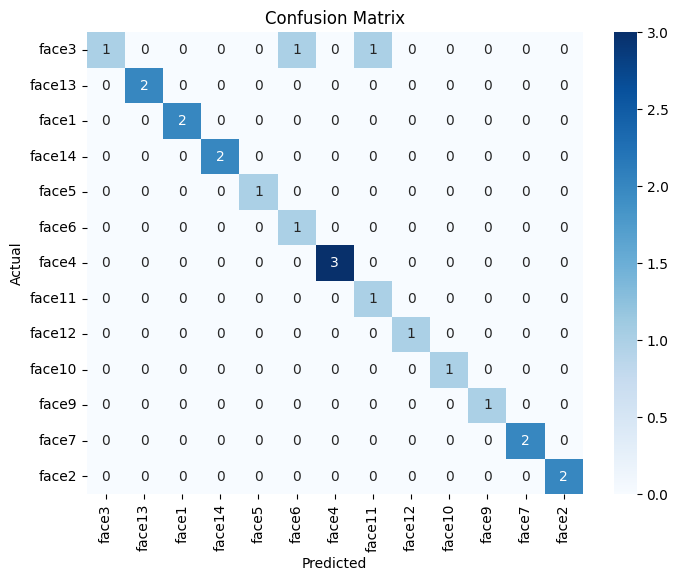

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the confusion matrix
confusion = confusion_matrix(true_labels, predicted_labels)

# Print the confusion matrix and accuracy
print('Confusion Matrix:')
#print(confusion)

# Combine the arrays to create a single list
combined_list = true_labels + predicted_labels

# Use a set to extract unique class labels
unique_class_labels = set(combined_list)

# Convert the set back to a list (if needed)
unique_class_labels_list = list(unique_class_labels)

# Mostramos la matriz de confusión en un heat map
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", xticklabels=unique_class_labels_list, yticklabels=unique_class_labels_list)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

### Referencias

https://thinkingneuron.com/face-recognition-using-deep-learning-cnn-in-python/